In [30]:
!pip install scikit-learn datasets

You should consider upgrading via the '/lnet/aic/personal/kydliceh/non_runable/NLP_venv/bin/python3 -m pip install --upgrade pip' command.


In [31]:
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.tokenize.toktok import ToktokTokenizer
from pathlib import Path
import functools

In [32]:
models_folder = Path("Baseline") / "pickled_models"
utils_folder = Path("utils")

In [33]:
dataset_script = Path("../final_dataset") / "dataset.py"

toktok = ToktokTokenizer()
tokenizer = functools.partial(toktok.tokenize)
stop_words = []
with open(utils_folder / "stopwords.txt", "r") as f:
    for line in f:
        stop_words.append(line.strip())


# Fit just once
vectorizer = TfidfVectorizer(max_features=15000, tokenizer=tokenizer, stop_words=stop_words, lowercase=True)
vectorizer_name = "tfidf_vectorizer.pkl"

In [34]:
from datasets import load_dataset
eval_dataset = load_dataset(str(dataset_script), split="validation")
train_dataset = load_dataset(str(dataset_script), split="train")
test_dataset = load_dataset(str(dataset_script), split="test")

Found cached dataset dataset (/home/kydliceh/.cache/huggingface/datasets/dataset/default/0.0.0/ae1ae1e3860ee4469bff36aafffa1e3a7028b93330adf3a2c4fd63cd9d4a07ae)
Found cached dataset dataset (/home/kydliceh/.cache/huggingface/datasets/dataset/default/0.0.0/ae1ae1e3860ee4469bff36aafffa1e3a7028b93330adf3a2c4fd63cd9d4a07ae)
Found cached dataset dataset (/home/kydliceh/.cache/huggingface/datasets/dataset/default/0.0.0/ae1ae1e3860ee4469bff36aafffa1e3a7028b93330adf3a2c4fd63cd9d4a07ae)


In [35]:
import pickle

In [36]:
vecorizer_path = models_folder / vectorizer_name
if vecorizer_path.exists():
    vectorizer = pickle.load(open(vecorizer_path, "rb"))
else:
    vectorizer.fit(train_dataset["content"])
    pickle.dump(vectorizer, open(models_folder / vectorizer_name , "wb"))

/lnet/aic/personal/kydliceh/non_runable/NLP_venv/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/lnet/aic/personal/kydliceh/non_runable/NLP_venv/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:409: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ["'", 'ted'] not in stop_words.
  warnings.warn(


In [37]:
train_path = models_folder / "train_tokenized.pkl"
eval_path = models_folder / "eval_tokenized.pkl"
test_path = models_folder / "test_tokenized.pkl"
if not train_path.exists():
    train_tokenized = vectorizer.transform(train_dataset["content"])
    pickle.dump(train_tokenized, open(train_path, "wb"))

if not eval_path.exists():
    eval_tokenized = vectorizer.transform(eval_dataset["content"])
    pickle.dump(eval_tokenized, open(eval_path, "wb"))

if not test_path.exists():
    test_tokenized = vectorizer.transform(test_dataset["content"])
    pickle.dump(test_tokenized, open(test_path, "wb"))

In [38]:
import matplotlib.pyplot as plt
import numpy as np

def report_stats(y):
    uniq, counts = np.unique(y, return_counts=True)
    max_i = np.argmax(counts)
    print(f"Length: {len(y)}")
    print(f"Length Unique values: {len(uniq)}")
    print(uniq)
    print(f"Baseline with max class {uniq[max_i]}: {counts[max_i] / len(y)}")

def plot_distribution(y):
    un, counts = np.unique(y, return_counts=True)
    plt.bar(un, counts)
    plt.show()

In [39]:
from Baseline.baseline_models import Model
from utils.dataset import Dataset
from sklearn.metrics import f1_score
from typing import Callable, Any, List
import functools

In [40]:
def test_model(model: Model, dataset: Dataset, show_stats=True, metric: Callable[[np.ndarray, np.ndarray], Any] | None = None ):
    y = dataset.y
    x = dataset.X
    if show_stats:
        plot_distribution(y)
        report_stats(y)

    if metric is None:
        return model.score(x, y)

    return metric(model.predict(x), y)

In [97]:
def train_model(model: Model, dataset: Dataset , validate_dataset: Dataset | None=None, hyperparams: List[dict]=[], metric: Callable | None = functools.partial(f1_score, average="macro"), cached: bool = True, cache_path: Path = Path("Baseline") / "pickled_models" / "cached_models"):
    best_params = model.get_params()
    best_score = float("-inf")
    if len(hyperparams) == 0:
        hyperparams = [{}]

    default_params = model.get_params()
    real_val_d = validate_dataset
    if real_val_d is None:
        print("No validation dataset using training dataset")
        real_val_d = dataset

    

    chosen_params = hyperparams[0]
        
    if not cache_path.exists() and cached:
        cache_path.mkdir(parents=True)

    for params in hyperparams:
        model_name = model.__class__.__name__ + "_".join([f"{k}_{v}" for k, v in params.items()]) + ".pkl"

        model_path = cache_path / model_name

        if model_path.exists() and cached:
            model.load(model_path)
        else:
            # Reset to default params
            model.set_params(**default_params)
            model.set_params(**params)
            model.fit(dataset.X, dataset.y)
            if cached:
                model.save(model_path)
            
        score = test_model(model, real_val_d, show_stats=False,metric=metric)
        if score > best_score:
            best_score = score
            best_params = model.get_params()
            chosen_params = params
            

    model.set_params(**best_params)
    print(f"Best params: {chosen_params}")

In [42]:
import itertools
# Get dictionary of potential hyperparameters and return a list of dictionaries with all possible combinations
def create_hyperparams(**kwargs):
    keys = kwargs.keys()
    values = kwargs.values()
    hyperparams = []
    for v in itertools.product(*values):
        hyperparams.append(dict(zip(keys, v)))
    return hyperparams


In [43]:
from utils.dataset import ArticleTFIDFDataset, remove_y_None
from Baseline.baseline_models import ServerModel

In [44]:
# Server prediction
serverDatasetTrain = ArticleTFIDFDataset(train_tokenized, train_dataset["server"], filter=remove_y_None)
serverDatasetDev = ArticleTFIDFDataset(eval_tokenized, eval_dataset["server"], filter=remove_y_None)
serverDatasetTest = ArticleTFIDFDataset(test_tokenized, test_dataset["server"], filter=remove_y_None)

In [45]:
server_model_file = models_folder / "server_model.pkl"
server_model = ServerModel()

In [49]:
# Training
hyperparams = create_hyperparams(
    C=[0.001, 0.1, 1]
)

if server_model_file.exists():
    server_model = pickle.load(open(server_model_file, "rb"))
else:
    train_model(server_model, serverDatasetTrain, serverDatasetDev, hyperparams=hyperparams)
    server_model.save(server_model_file)

[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =        90006     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.19472D+06    |proj g|=  5.67489D+05


 This problem is unconstrained.



At iterate   50    f=  2.18417D+06    |proj g|=  1.48550D+02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
90006     71     78      1     0     0   1.070D+01   2.184D+06
  F =   2184163.2213442200     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


[Parallel(n_jobs=8)]: Done   1 out of   1 | elapsed:  4.5min finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =        90006     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.19472D+06    |proj g|=  5.67489D+05


 This problem is unconstrained.



At iterate   50    f=  1.43550D+06    |proj g|=  1.01569D+04

At iterate  100    f=  1.33388D+06    |proj g|=  1.09561D+04

At iterate  150    f=  1.31992D+06    |proj g|=  1.01762D+03

At iterate  200    f=  1.31762D+06    |proj g|=  7.10549D+02

At iterate  250    f=  1.31716D+06    |proj g|=  1.39253D+02

At iterate  300    f=  1.31706D+06    |proj g|=  2.52424D+02

At iterate  350    f=  1.31704D+06    |proj g|=  3.30938D+01

At iterate  400    f=  1.31704D+06    |proj g|=  5.80849D+01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
90006    444    480      1     0     0   1.412D+01   1.317D+06
  F =   1317035.33800

[Parallel(n_jobs=8)]: Done   1 out of   1 | elapsed: 27.0min finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =        90006     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.19472D+06    |proj g|=  5.67489D+05


 This problem is unconstrained.



At iterate   50    f=  1.34335D+06    |proj g|=  4.32003D+04

At iterate  100    f=  1.20082D+06    |proj g|=  5.45878D+03

At iterate  150    f=  1.15675D+06    |proj g|=  6.06751D+03

At iterate  200    f=  1.13847D+06    |proj g|=  4.48055D+03

At iterate  250    f=  1.13095D+06    |proj g|=  4.25290D+03

At iterate  300    f=  1.12730D+06    |proj g|=  1.13125D+03

At iterate  350    f=  1.12538D+06    |proj g|=  2.19056D+02

At iterate  400    f=  1.12425D+06    |proj g|=  4.79055D+02

At iterate  450    f=  1.12378D+06    |proj g|=  5.38016D+02

At iterate  500    f=  1.12346D+06    |proj g|=  1.97620D+02

At iterate  550    f=  1.12326D+06    |proj g|=  7.42781D+02

At iterate  600    f=  1.12315D+06    |proj g|=  2.56488D+02

At iterate  650    f=  1.12309D+06    |proj g|=  4.33205D+01

At iterate  700    f=  1.12306D+06    |proj g|=  2.78235D+02

At iterate  750    f=  1.12304D+06    |proj g|=  3.06278D+01

At iterate  800    f=  1.12303D+06    |proj g|=  6.57485D+01

At iter

/lnet/aic/personal/kydliceh/non_runable/NLP_venv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
[Parallel(n_jobs=8)]: Done   1 out of   1 | elapsed: 62.2min finished


Best params: {'C': 1}


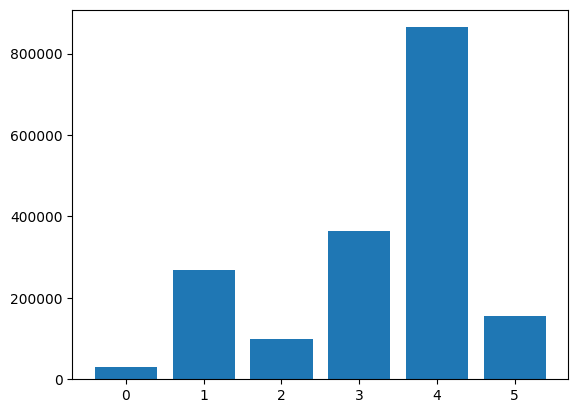

Length: 1783006
Length Unique values: 6
[0 1 2 3 4 5]
Baseline with max class 4: 0.4849434045650996
              precision    recall  f1-score   support

           0       0.73      0.43      0.54     30943
           1       0.70      0.55      0.62    268150
           2       0.73      0.66      0.69     99670
           3       0.75      0.77      0.76    364876
           4       0.83      0.92      0.87    864657
           5       0.72      0.62      0.67    154710

    accuracy                           0.78   1783006
   macro avg       0.74      0.66      0.69   1783006
weighted avg       0.78      0.78      0.78   1783006



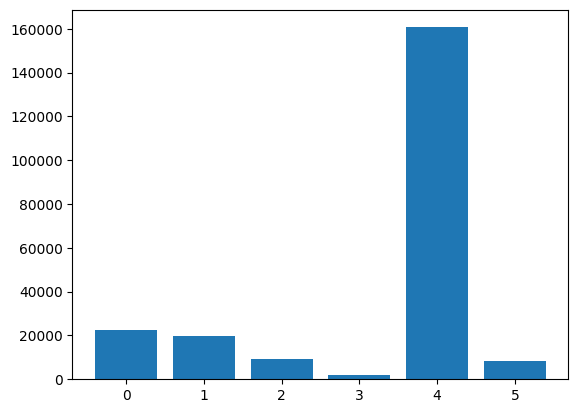

Length: 222876
Length Unique values: 6
[0 1 2 3 4 5]
Baseline with max class 4: 0.721131929862345
              precision    recall  f1-score   support

           0       0.66      0.22      0.33     22662
           1       0.27      0.37      0.31     19934
           2       0.43      0.51      0.47      9340
           3       0.07      0.51      0.13      2086
           4       0.85      0.80      0.82    160723
           5       0.29      0.42      0.34      8131

    accuracy                           0.67    222876
   macro avg       0.43      0.47      0.40    222876
weighted avg       0.74      0.67      0.69    222876



In [50]:
print(test_model(server_model, serverDatasetTrain))
print(test_model(server_model, serverDatasetTest))

In [51]:
# Category prediction
categoryDatasetTrain = ArticleTFIDFDataset(train_tokenized, train_dataset["category"] , filter=remove_y_None)
categoryDatasetDev = ArticleTFIDFDataset(eval_tokenized, eval_dataset["category"] , filter=remove_y_None)
categoryDatasetTest = ArticleTFIDFDataset(test_tokenized, test_dataset["category"] , filter=remove_y_None)

In [52]:
from Baseline.baseline_models import CategoryModel
category_model_file = models_folder / "category_model.pkl"
category_model = CategoryModel()

In [59]:
# Training
hyperparams = create_hyperparams(
    C=[0.001, 0.1, 1]
)

if category_model_file.exists():
    category_model = category_model.load(category_model_file)
else:
    category_model = train_model(category_model, categoryDatasetTrain, categoryDatasetDev, hyperparams=hyperparams)
    category_model.save(category_model_file)

[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =       750050     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.10387D+06    |proj g|=  1.40833D+05


 This problem is unconstrained.


KeyboardInterrupt: 

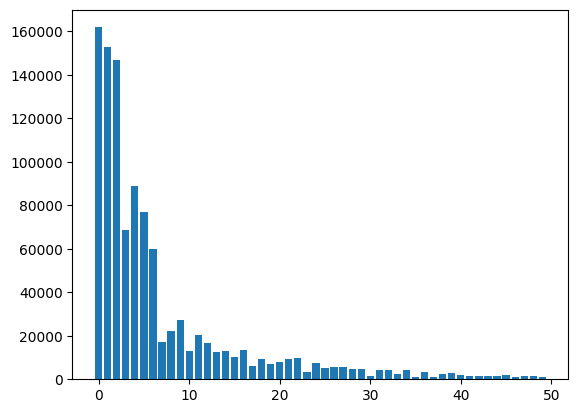

Length: 1049040
Length Unique values: 50
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49]
Baseline with max class 0: 0.15424959963395105
              precision    recall  f1-score   support

           0       0.84      0.91      0.87    161814
           1       0.75      0.79      0.77    152599
           2       0.84      0.96      0.89    146572
           3       0.67      0.66      0.67     68510
           4       0.79      0.91      0.84     88783
           5       0.71      0.77      0.74     76970
           6       0.76      0.84      0.79     59763
           7       0.81      0.72      0.77     17236
           8       0.79      0.73      0.76     22120
           9       0.68      0.68      0.68     27378
          10       0.75      0.48      0.59     12874
          11       0.73      0.78      0.76     20533
          12       0.83      0.83      0.83     16626
 

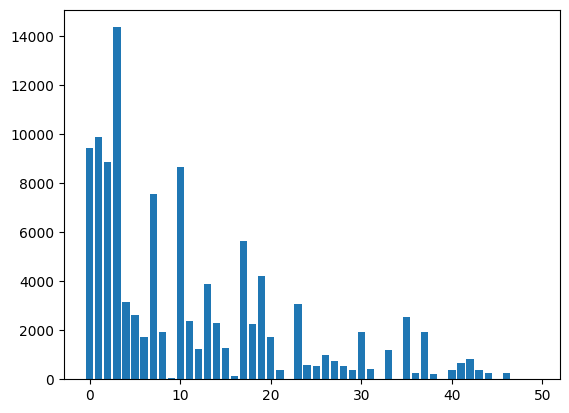

Length: 111890
Length Unique values: 46
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 23 24
 25 26 27 28 29 30 31 33 35 36 37 38 39 40 41 42 43 44 45 46 47 49]
Baseline with max class 3: 0.1284207703994995
              precision    recall  f1-score   support

           0       0.65      0.85      0.74      9440
           1       0.50      0.75      0.60      9897
           2       0.32      0.90      0.48      8863
           3       0.62      0.56      0.59     14369
           4       0.28      0.88      0.43      3161
           5       0.29      0.66      0.40      2627
           6       0.40      0.49      0.44      1736
           7       0.31      0.17      0.22      7565
           8       0.39      0.49      0.44      1946
           9       0.02      0.25      0.03        64
          10       0.59      0.08      0.14      8670
          11       0.23      0.33      0.27      2392
          12       0.78      0.72      0.75      1235
          13    

/lnet/aic/personal/kydliceh/non_runable/NLP_venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/lnet/aic/personal/kydliceh/non_runable/NLP_venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/lnet/aic/personal/kydliceh/non_runable/NLP_venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(a

In [ ]:
print(test_model(category_model, categoryDatasetTrain))
print(test_model(category_model, categoryDatasetTest))

In [72]:
# Gender prediction
from utils.dataset import gender_type_transform


genderDatasetTrain = ArticleTFIDFDataset(train_tokenized, train_dataset["authors_gender"], transform_Y=gender_type_transform, filter=remove_y_None)
genderDatasetDev = ArticleTFIDFDataset(eval_tokenized, eval_dataset["authors_gender"], transform_Y=gender_type_transform, filter=remove_y_None)

genderDatasetTest = ArticleTFIDFDataset(test_tokenized, test_dataset["authors_gender"], transform_Y=gender_type_transform ,filter=remove_y_None)


In [69]:
%load_ext autoreload
%autoreload 2

In [70]:
from Baseline.baseline_models import AuthorGenderModelSimple
gender_model = AuthorGenderModelSimple()
gender_model_file = models_folder / "author_gender_model.pkl"

In [73]:
# Training
hyperparams = create_hyperparams(
    C=[0.001, 0.1, 1, 10]
)

if gender_model_file.exists():
    gender_model = gender_model.load(gender_model_file)
else:
    gender_model = train_model(gender_model, genderDatasetTrain, genderDatasetDev, hyperparams=hyperparams)
    gender_model.save(gender_model_file)

[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =        45003     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.33334D+06    |proj g|=  3.70656D+05


 This problem is unconstrained.


KeyboardInterrupt: 

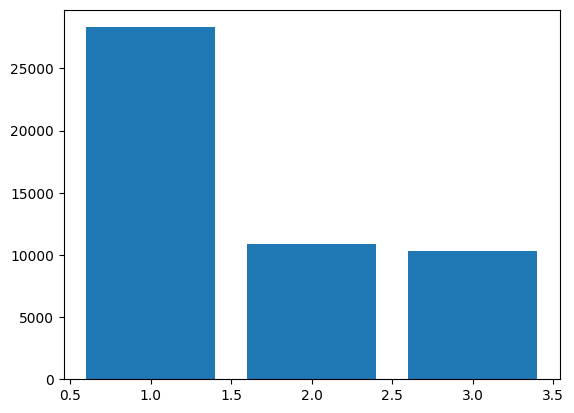

Length: 49477
Length Unique values: 3
[1 2 3]
Baseline with max class 1: 0.572083998625624
              precision    recall  f1-score   support

           1       0.78      0.91      0.84     28305
           2       0.75      0.44      0.56     10879
           3       0.68      0.65      0.66     10293

    accuracy                           0.75     49477
   macro avg       0.73      0.67      0.69     49477
weighted avg       0.75      0.75      0.74     49477



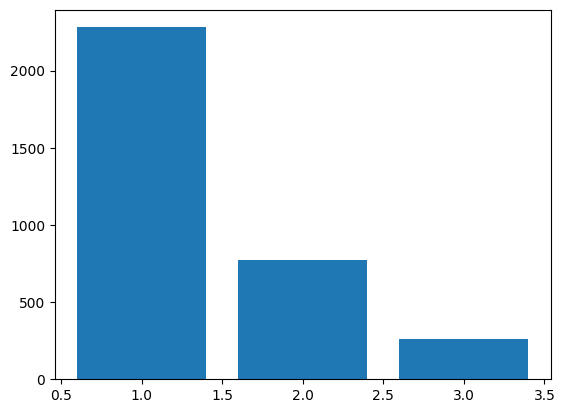

Length: 3314
Length Unique values: 3
[1 2 3]
Baseline with max class 1: 0.6882920941460471
              precision    recall  f1-score   support

           1       0.77      0.86      0.81      2281
           2       0.58      0.32      0.41       772
           3       0.34      0.44      0.39       261

    accuracy                           0.70      3314
   macro avg       0.56      0.54      0.53      3314
weighted avg       0.69      0.70      0.68      3314



In [ ]:
print(test_model(model, genderDatasetTrain))
print(test_model(model, genderDatasetTest))

In [101]:
# Day prediction
from Baseline.baseline_models import DayModel

dayDatasetTrain = ArticleTFIDFDataset(train_tokenized, train_dataset["day_of_week"] , filter=remove_y_None)
dayDatasetDev = ArticleTFIDFDataset(eval_tokenized, eval_dataset["day_of_week"] , filter=remove_y_None)
dayDatasetTest = ArticleTFIDFDataset(test_tokenized, test_dataset["day_of_week"] , filter=remove_y_None)

In [109]:
day_model_file = models_folder / "day_model.pkl"
day_model = DayModel()

In [125]:
tr = vectorizer.get_feature_names_out()
tr

In [127]:
tr = vectorizer.get_feature_names_out()
with open("features.txt", "w") as f:
    f.writelines([f"{t}\n" for t in tr])

In [111]:
# Training
hyperparams = create_hyperparams(
    C=[0.001, 0.1, 1, 10]
)

if day_model_file.exists():
    day_model.load(day_model_file)
else:
    train_model(day_model, dayDatasetTrain, dayDatasetDev, hyperparams=hyperparams, cached=True)
    day_model.save(day_model_file)

[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =       105007     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.46957D+06    |proj g|=  1.01382D+05


 This problem is unconstrained.



At iterate   50    f=  3.40376D+06    |proj g|=  1.05518D+01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
*****     50     54      1     0     0   1.055D+01   3.404D+06
  F =   3403764.1752397143     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


[Parallel(n_jobs=8)]: Done   1 out of   1 | elapsed:  3.7min finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =       105007     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.46957D+06    |proj g|=  1.01382D+05


 This problem is unconstrained.



At iterate   50    f=  3.28563D+06    |proj g|=  1.59843D+04

At iterate  100    f=  3.25640D+06    |proj g|=  3.74660D+03

At iterate  150    f=  3.24992D+06    |proj g|=  1.33582D+03

At iterate  200    f=  3.24833D+06    |proj g|=  3.33128D+02

At iterate  250    f=  3.24787D+06    |proj g|=  3.37225D+02

At iterate  300    f=  3.24775D+06    |proj g|=  1.61910D+02

At iterate  350    f=  3.24770D+06    |proj g|=  9.94809D+01

At iterate  400    f=  3.24769D+06    |proj g|=  1.45170D+01

At iterate  450    f=  3.24769D+06    |proj g|=  4.54787D+01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
*****    450    482   

[Parallel(n_jobs=8)]: Done   1 out of   1 | elapsed: 30.9min finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =       105007     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.46957D+06    |proj g|=  1.01382D+05


 This problem is unconstrained.



At iterate   50    f=  3.27400D+06    |proj g|=  1.28517D+04


KeyboardInterrupt: 

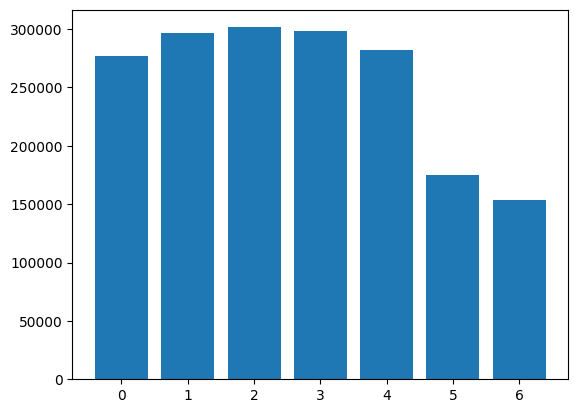

Length: 1783006
Length Unique values: 7
[0 1 2 3 4 5 6]
Baseline with max class 2: 0.16906617251989056
              precision    recall  f1-score   support

           0       0.20      0.24      0.22    277087
           1       0.23      0.21      0.22    296637
           2       0.22      0.30      0.25    301446
           3       0.23      0.19      0.21    298061
           4       0.20      0.30      0.24    281756
           5       0.15      0.08      0.10    174686
           6       0.24      0.00      0.01    153333

    accuracy                           0.21   1783006
   macro avg       0.21      0.19      0.18   1783006
weighted avg       0.21      0.21      0.20   1783006



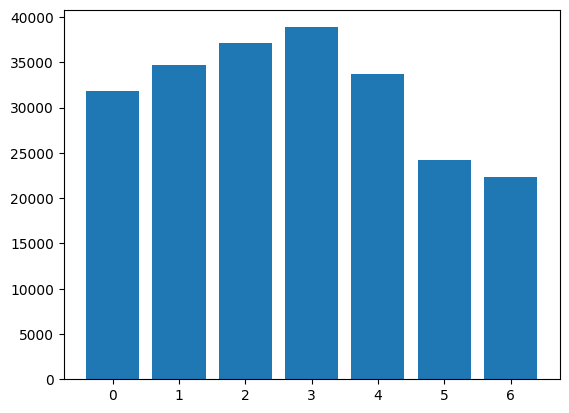

Length: 222876
Length Unique values: 7
[0 1 2 3 4 5 6]
Baseline with max class 3: 0.17442434358118417
              precision    recall  f1-score   support

           0       0.18      0.19      0.18     31842
           1       0.21      0.15      0.17     34731
           2       0.21      0.20      0.20     37104
           3       0.22      0.24      0.23     38875
           4       0.17      0.30      0.21     33745
           5       0.12      0.13      0.13     24196
           6       0.04      0.00      0.00     22383

    accuracy                           0.18    222876
   macro avg       0.16      0.17      0.16    222876
weighted avg       0.17      0.18      0.17    222876



In [ ]:
print(test_model(day_model, dayDatasetTrain))
print(test_model(day_model, dayDatasetTest))